In [1]:
import tempfile
import json
from pathlib import Path
from PyPDF2 import PdfReader
from docx import Document as DocxDocument
import pytesseract
from pdf2image import convert_from_path
from langchain_groq import ChatGroq
from langchain.schema import HumanMessage, SystemMessage

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()  

True

In [3]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [4]:
llm = ChatGroq(
    model="llama3-8b-8192",
    api_key=os.getenv("GROQ_API_KEY")
)
print(llm)

client=<groq.resources.chat.completions.Completions object at 0x000002A650F1E8A0> async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002A651096B70> model_name='llama3-8b-8192' model_kwargs={} groq_api_key=SecretStr('**********')


In [9]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
from PIL import Image
img = Image.new('RGB', (100, 30), color='white')
print(pytesseract.image_to_string(img))  

In [10]:
from docx import Document as DocxDocument
from docx.opc.constants import RELATIONSHIP_TYPE as RT
from PIL import Image
import io

def extract_text_and_images(uploaded_file):
    suffix = Path(uploaded_file.name).suffix.lower()
    text = ""
    ocr_text = ""
    image_list = []

    with tempfile.NamedTemporaryFile(delete=False, suffix=suffix) as tmp_file:
        tmp_file.write(uploaded_file.read())
        tmp_file_path = tmp_file.name

    try:
        if suffix == ".pdf":
            try:
                reader = PdfReader(tmp_file_path)
                text = "\n".join([page.extract_text() or "" for page in reader.pages])
            except:
                text = ""
                
            images = convert_from_path(tmp_file_path)
            image_list.extend(images)
            ocr_text = " ".join([pytesseract.image_to_string(img) for img in images])

        elif suffix == ".docx":
            doc = DocxDocument(tmp_file_path)
            text = "\n".join([para.text for para in doc.paragraphs])

            rels = doc.part._rels
            for rel in rels:
                rel = rels[rel]
                if rel.reltype == RT.IMAGE:
                    image_data = rel.target_part.blob
                    image = Image.open(io.BytesIO(image_data))
                    image_list.append(image)
                    ocr_text += pytesseract.image_to_string(image) + "\n"

        elif suffix == ".txt":
            with open(tmp_file_path, "r", encoding="utf-8") as f:
                text = f.read()

        else:
            text = f"Unsupported file type: {suffix}"

    finally:
        os.remove(tmp_file_path)

    return {
        "text": text.strip(),
        "ocr_text": ocr_text.strip(),
        "images": image_list  
    }


Extracted Text:
 EEG signals are inherently noisy due to various artifacts such as muscle activity, eye movements, and environmental interference. Denoising techniques aim to isolate neural activity from these contaminating sources to improve signal quality for downstream analysis. Traditional methods like bandpass filtering and Independent Component Analysis (ICA) have been widely used, but often fail when artifact sources overlap in frequency or spatially. More recent approaches leverage adaptive filters such as the Recursive Least Squares (RLS) algorithm or data-driven models like convolutional neural networks (CNNs) and U-Nets to capture temporal and spatial dependencies. Effective denoising not only enhances brain-computer interface (BCI) performance but also increases the reliability of clinical interpretations in EEG-based diagnosis.

OCR Text:
 EEG Denoising - Simulation 54, Channel 0

3
2
1
oO
»
3
2
B-1
E
&
—2
3
-4 — Pure Signal (Normalized)
=-- Cleaned by U-Net

0 1000 2000 3

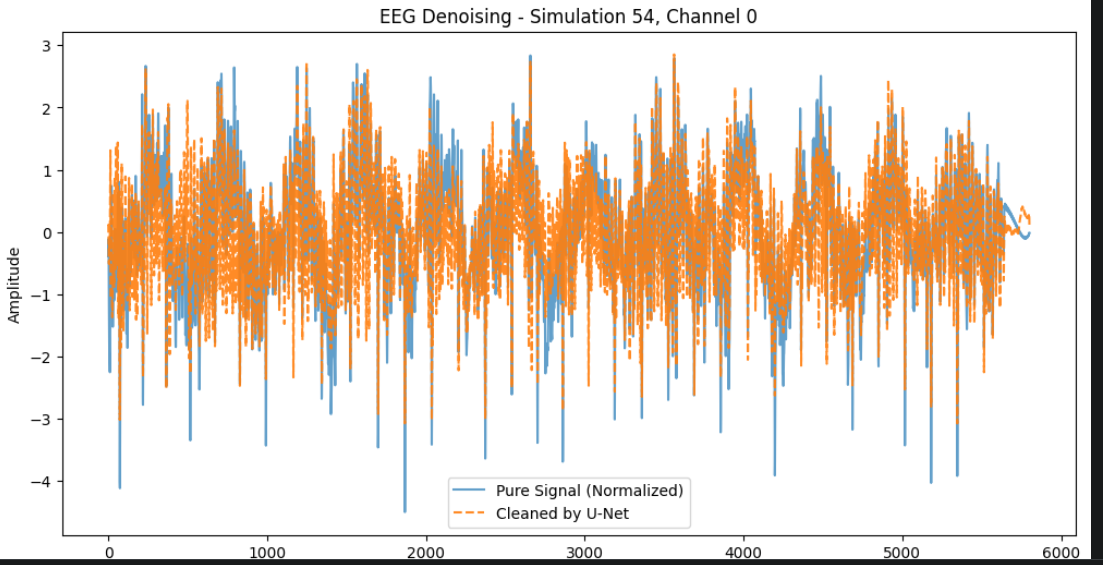

In [11]:
from pathlib import Path

class UploadFile:
    def __init__(self, file_path):
        self.name = Path(file_path).name
        self.file = open(file_path, 'rb')
    def read(self):
        return self.file.read()
    def close(self):
        self.file.close()

uploaded_file = UploadFile("test.docx")

result = extract_text_and_images(uploaded_file)

print("Extracted Text:\n", result["text"])
print("\nOCR Text:\n", result["ocr_text"])
print("\nNumber of Images Found:", len(result["images"]))

from IPython.display import display
if result["images"]:
    display(result["images"][0])


In [12]:
def generate_metadata(text):
    prompt = f"""
You are a wonderful and best metadata assistant.
Analyze the following document and return structured metadata in JSON format with fields:
- title
- summary
- keywords
- topics
- author (if mentioned)
- document_type 
Try to explain the summary in detail please,and atleast 9-10 lines in a paragraph.Kindly dont miss any important points in summary
Document:
{text}
"""
    response = llm([
        SystemMessage(content="You are a metadata extraction assistant."),
        HumanMessage(content=prompt)
    ])
    return response.content.strip()

In [15]:
generate_metadata(result['text'])
generate_metadata(result['ocr_text'])

'Here is the metadata extracted from the document in JSON format:\n\n```\n{\n  "title": "EEG Denoising - Simulation 54, Channel 0",\n  "summary": "This document appears to be a graph or plot related to EEG denoising, showing the normalized pure signal and the cleaned signal using a U-Net algorithm. The graph displays a time series of EEG data, with the x-axis representing time and the y-axis representing the signal amplitude. The signal is cleaned by removing noise, resulting in a smoother and more accurate representation of the original signal. The cleaned signal is compared to the pure signal, highlighting the effectiveness of the U-Net algorithm in denoising the EEG data. The graph is divided into sections, with each section representing a different stage of the denoising process. The graph also includes labels and annotations, providing additional context and information about the signal and the denoising process. Overall, this document provides a visual representation of the denoi